### Importing the Librairies

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet as wn

from wordcloud import WordCloud
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.metrics import roc_curve, auc,f1_score

### Importing the Data

In [16]:
df = pd.read_excel('reviews_amazon_labels.xlsx')

In [17]:
df = df.drop('DOC_ID',axis=1)

In [18]:
df.head(2)

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...


### Understanding the data

In [19]:
df.shape

(21000, 8)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   LABEL              21000 non-null  object
 1   RATING             21000 non-null  int64 
 2   VERIFIED_PURCHASE  21000 non-null  object
 3   PRODUCT_CATEGORY   21000 non-null  object
 4   PRODUCT_ID         21000 non-null  object
 5   PRODUCT_TITLE      21000 non-null  object
 6   REVIEW_TITLE       20999 non-null  object
 7   REVIEW_TEXT        21000 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.3+ MB


In [21]:
df.describe()

,RATING
count,21000.000000
mean,4.127952
std,1.278333
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [22]:
df.describe(include='O').T

,count,unique,top,freq
LABEL,21000,2,__label1__,10500
VERIFIED_PURCHASE,21000,2,Y,11698
PRODUCT_CATEGORY,21000,30,PC,700
PRODUCT_ID,21000,18857,B0010O748Q,4
PRODUCT_TITLE,21000,18865,Honey Badger Garden Gloves for Digging & Plant...,5
REVIEW_TITLE,20999,18475,Five Stars,83
REVIEW_TEXT,21000,21000,"When least you think so, this product will sav...",1


### Null Value Treatment

In [23]:
(df.isnull().sum()/len(df))*100


LABEL                0.000000
RATING               0.000000
VERIFIED_PURCHASE    0.000000
PRODUCT_CATEGORY     0.000000
PRODUCT_ID           0.000000
PRODUCT_TITLE        0.000000
REVIEW_TITLE         0.004762
REVIEW_TEXT          0.000000
dtype: float64

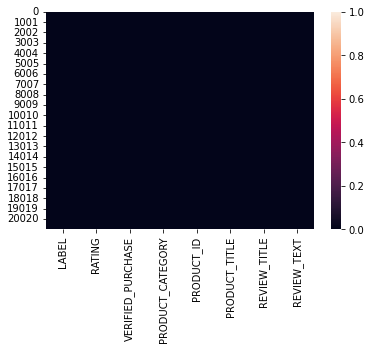

In [24]:
sns.heatmap(df.isnull())
plt.show()

### Dummy Encoding

In [25]:
le = LabelEncoder()

In [26]:
df['LABEL'] = le.fit_transform(df['LABEL'])

In [27]:
df['VERIFIED_PURCHASE'] = le.fit_transform(df['VERIFIED_PURCHASE'])

In [28]:
df['RATING'] = le.fit_transform(df['RATING'])

## Visualisation

### Univariate Analysis

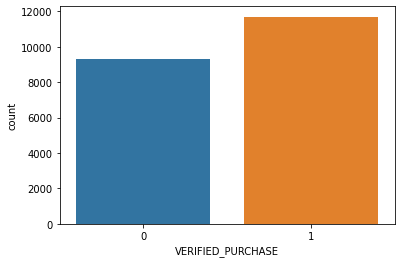

In [29]:
sns.countplot(df['VERIFIED_PURCHASE'])
plt.show()

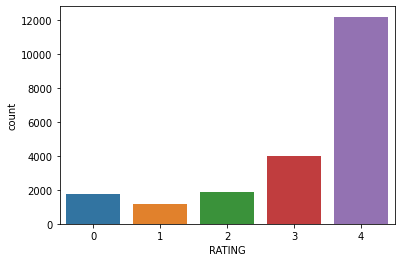

In [30]:
sns.countplot(df['RATING'])
plt.show()

#### Target Variable

In [31]:
df['LABEL'].unique()

array([0, 1])

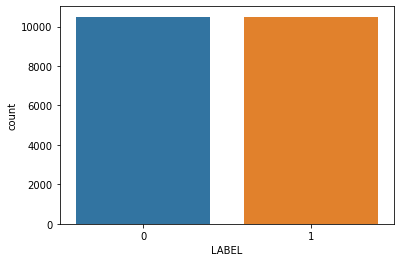

In [32]:
sns.countplot(df['LABEL'])
plt.show()

### Bi-Variate Analysis

#### Finding the relation between other variables with Target Variable

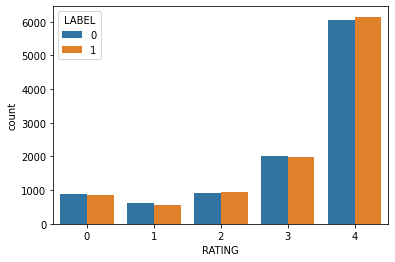

In [33]:
sns.countplot(df['RATING'],hue=df['LABEL'])
plt.show()

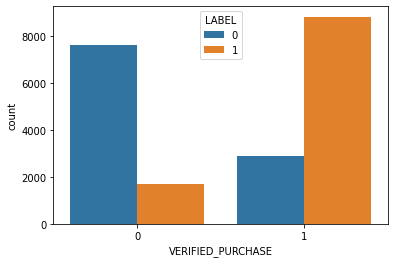

In [34]:
sns.countplot(df['VERIFIED_PURCHASE'],hue=df['LABEL'])
plt.show()

### Multivariate Analysis

## Pre-Processing Steps in NLP for REVIEW_TEXT Column

In [35]:
lemmatizer = WordNetLemmatizer()
#stemmer = PorterStemmer()

In [36]:
def lemmatizing(word):
    lematize = WordNetLemmatizer()
    if(word != lematize.lemmatize(word,pos ='a')):
        return lematize.lemmatize(word,pos ='a')
    elif(word != lematize.lemmatize(word,pos ='v')):
        return lematize.lemmatize(word,pos ='v')
    else:
        return word

In [37]:
# def cleanhtml(raw_html):
#     cleanr = re.compile('<.*?>')
#     cleantext = re.sub(cleanr, '', raw_html)
#     return cleantext

In [38]:
# def lemmatizing_spell_check(word):  
#     if(word != lematize.lemmatize(word,pos ='a')):
#         word =  lematize.lemmatize(word,pos ='a')
#     elif(word != lematize.lemmatize(word,pos ='v')):
#         word  =  lematize.lemmatize(word,pos ='v')
#     #spell checking
# #     if(word != str(spell.correction(word))):
# #         return str(spell.correction(word))
# #     else:
# #         word = TextBlob(word)
# #         word = str(word.correct())
#     return word

In [39]:
def preprocessing(x):
    x = x.lower()   # Lower case conversion
    cleanr = re.compile('<.*?>') # Removing tags
    a = re.sub(cleanr, '', x)
    a = re.findall('[a-z0-9]+', a) # Removing Punctations
    filtered_sentence = [w for w in a if w not in set(stopwords.words('english'))] # Removing Stop words
    #filtered_sentence = list(map(spellChecker,filtered_sentence)) # Spelling checker
    filtered_sentence = list(map(lemmatizing,filtered_sentence)) # Lemmatising the words
    return ' '.join(filtered_sentence)

In [40]:
clean_review_df=pd.DataFrame({'LABEL':df['LABEL'],'REVIEW_TEXT':df['REVIEW_TEXT']})
clean_review_df.head(4)

,LABEL,REVIEW_TEXT
0,0,"When least you think so, this product will sav..."
1,0,Lithium batteries are something new introduced...
2,0,I purchased this swing for my baby. She is 6 m...
3,0,I was looking for an inexpensive desk calcolat...


In [41]:
df.head(4)

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,0,3,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,0,3,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,0,2,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,0,3,0,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...


In [42]:
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [43]:
clean_review_df['CLEAN_TEXT'] = df['REVIEW_TEXT'].apply(preprocessing)

In [44]:
clean_review_df.head(2)

,LABEL,REVIEW_TEXT,CLEAN_TEXT
0,0,"When least you think so, this product will sav...",least think product save day keep around case ...
1,0,Lithium batteries are something new introduced...,lithium batteries something new introduce mark...


In [45]:
len(clean_review_df)

21000

## Word Cloud 

### Word Cloud for REVIEW_TEXT column

In [46]:
reviews_list = [review for review in clean_review_df['REVIEW_TEXT']]
review_text_words = ' '.join([i for word in reviews_list for i in word.split()])

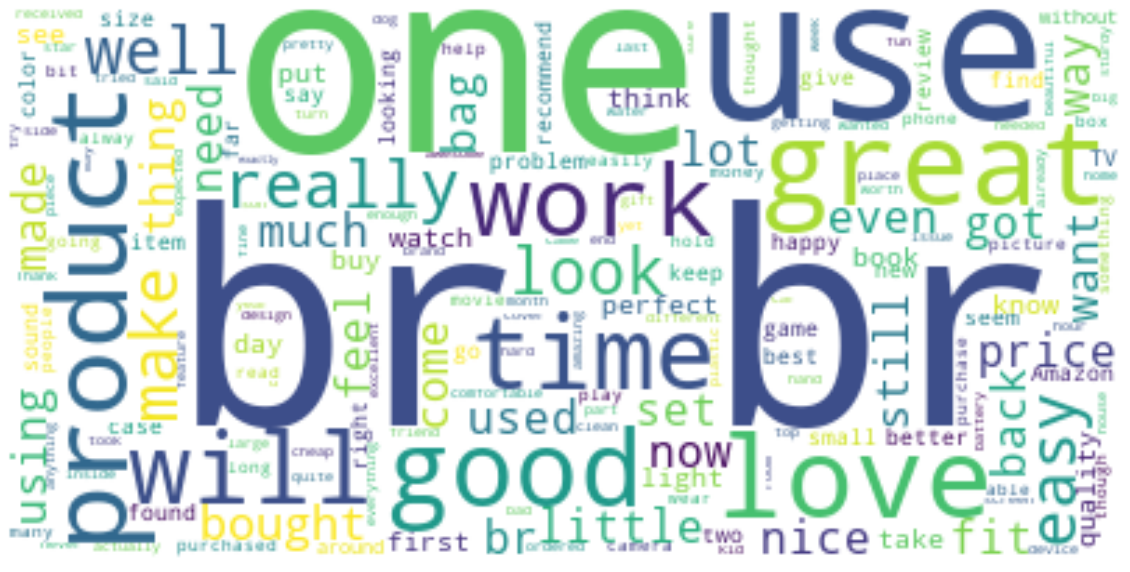

In [47]:
wordcloud_review_text = WordCloud(background_color="white").generate(review_text_words)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_review_text, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud for CLEAN_REVIEW_TEXT Column

In [48]:
clean_reviews_list = [review for review in clean_review_df['CLEAN_TEXT']]
clean_review_text_words = ' '.join([i for word in clean_reviews_list for i in word.split()])

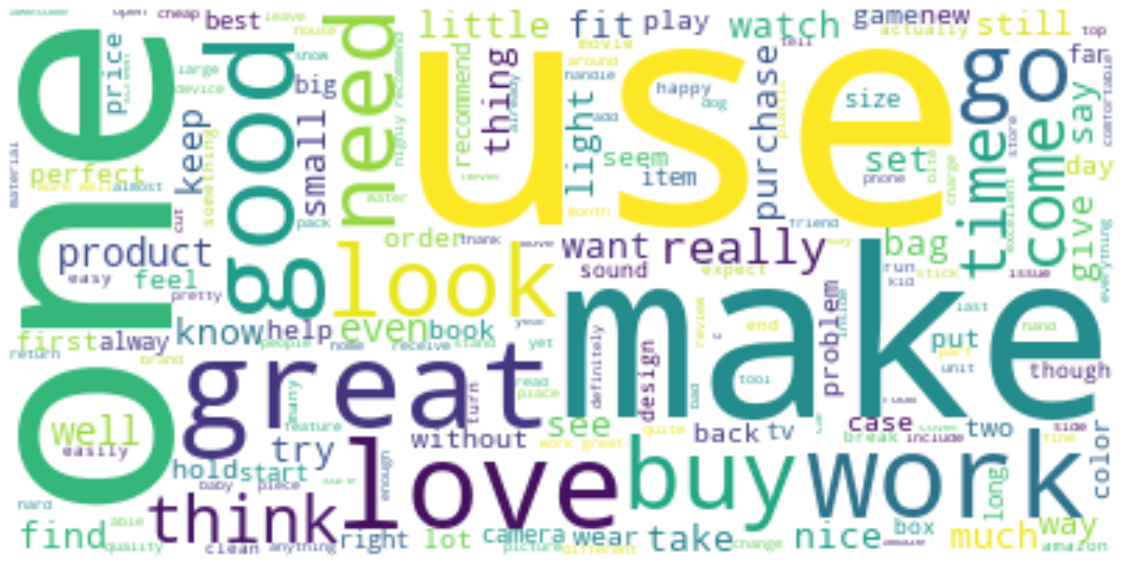

In [49]:
wordcloud_clean_review_text = WordCloud(background_color="white").generate(clean_review_text_words)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_clean_review_text, interpolation='bilinear')
plt.axis("off")
plt.show()

In [50]:
df_final=pd.DataFrame({'LABEL':clean_review_df['LABEL'],'CLEAN_TEXT':clean_review_df['CLEAN_TEXT']})
df_final.head(2)

,LABEL,CLEAN_TEXT
0,0,least think product save day keep around case ...
1,0,lithium batteries something new introduce mark...
